# Model + noise + downsampling workflow

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pyleoclim as pyleo

In [2]:
#stopgap until paleobeasts is a package

import sys
import os

cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)

sys.path.append(parent_dir)
from signal_models.g24 import Model3, calc_df, calc_f
from signal_models.forcing import Forcing
from signal_models.solver_util import Solver
from utils.downsample import downsample
from utils.noise import from_series, from_param

### First step : Initializing and solving the model

See the Ganopolski2024_demo notebook for details.

In [3]:
A = 25
eps = 0.5

g24_forcing = Forcing(calc_f, derivative=calc_df, params = {'A':A, 'eps':eps})

f1 = -16
f2 = 16
vc = 1.47
t1 = 30
t2 = 10

model3 = Model3(forcing=g24_forcing, var_name='ice volume', vc=vc, f1=f1, f2=f2, t1=t1, t2=t2)

v_init= 0
k_init = 1
length = 1200
t0 = 0
tend = t0+length
delta_t=1

model3.state_variables=[[k_init]]

model3_euler = Solver(model3, method='euler', t_span=(t0, tend), y0=[v_init], kwargs={'dt':delta_t})
model3_euler.integrate()


/Users/alexjames/GitHub/PaleoBeasts/signal_models/g24.py:164: RuntimeWarning: invalid value encountered in sqrt
  return 1 + np.sqrt((self.f2 - f) / (self.f2 - self.f1))
/Users/alexjames/GitHub/PaleoBeasts/signal_models/g24.py:181: RuntimeWarning: invalid value encountered in sqrt
  return 1 - np.sqrt((self.f2 - f) / (self.f2 - self.f1))


Create a basic pyleoclim Series object from the model. Time name and units are arbitrary here (for our purposes anyway).

In [4]:
model_series = pyleo.Series(
    time=model3_euler.solution.t, 
    value=model3_euler.solution.y[:,0], 
    label='ice volume',
    time_name = 'Age',
    time_unit='ka',
    auto_time_params=True)

Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Age [ka]', ylabel='value'>)

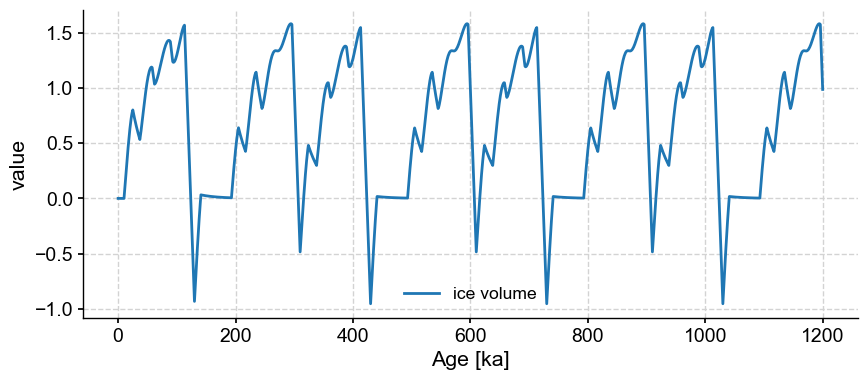

In [5]:
model_series.plot()

Looks good, now lets add some AR(1) noise:

In [26]:
series = model_series.copy()

noise_series = from_param(
    method='uar1',
    noise_param=[5,1],
    time_pattern='specified',
    settings={'time':model_series.time},
    scale = .2
)

series.value += noise_series.value

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Age [ka]', ylabel='value'>)

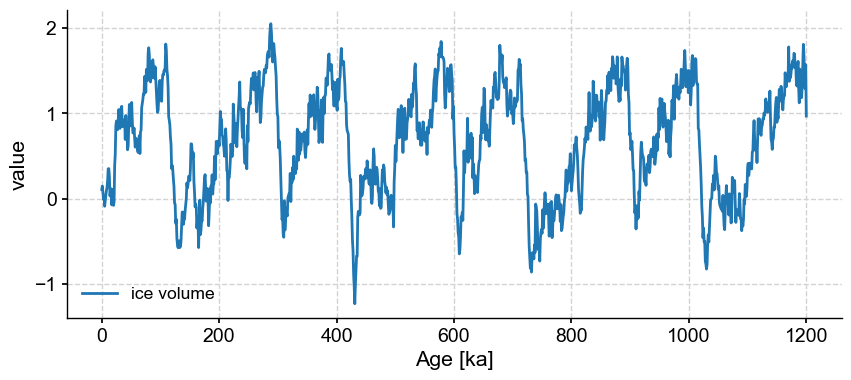

In [27]:
series.plot()

We can go ahead and downsample a bit too:

In [32]:
#Downsampling the data series using the default parameters (method='exponential' and param=1)
downsampled_series = downsample(series,seed=42,method='poisson',param=[2])

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Age [ka]', ylabel='value'>)

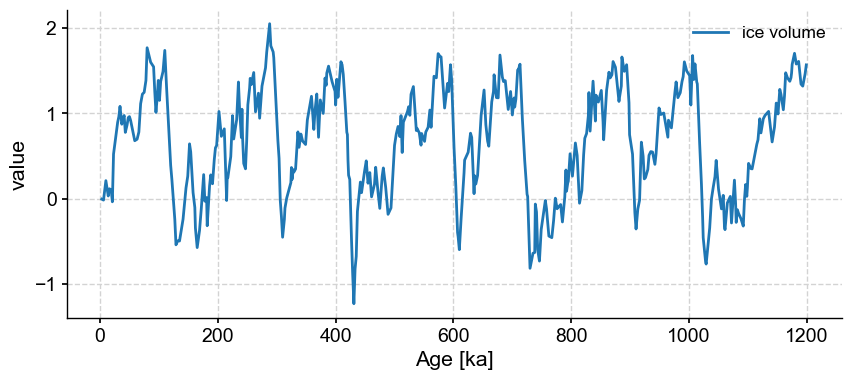

In [33]:
downsampled_series.plot()

Feel free to play around further!